In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive


[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive


In [ ]:
cd My Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive


In [ ]:
INPUT_SIZE = (256, 256)
mapping = { 'normal': 0, 'COVID-19': 1}

sample 144 bacterial pneumonia images for binary classification

In [ ]:
"""import random
filename = '/content/drive/My Drive/data/train/normal/normal'
nums = random.sample(range(0, 1349), 144)"""

"import random\nfilename = '/content/drive/My Drive/data/train/normal/normal'\nnums = random.sample(range(0, 1349), 144)"

In [ ]:
"""import shutil, os
files = []
dest_folder = '/content/drive/My Drive/covid-viral/'
for i in nums:
  src=''
  src = filename + (str)(i).zfill(4) +'.jpeg'
  files.append(src)
for f in files:
    shutil.copy(f, dest_folder)"""

"import shutil, os\nfiles = []\ndest_folder = '/content/drive/My Drive/covid-viral/'\nfor i in nums:\n  src=''\n  src = filename + (str)(i).zfill(4) +'.jpeg'\n  files.append(src)\nfor f in files:\n    shutil.copy(f, dest_folder)"

In [ ]:
import glob  
X=[]
y=[]

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid-viral/*viral*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  X.append(img)
  y.append(0)


In [ ]:
for im in glob.glob('/content/drive/My Drive/covid-viral/covid*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  X.append(img)
  y.append(1)

In [ ]:
print(len(X))
print(len(y))

288
288


Preprocess x_train

In [ ]:
gamma=0.5 
for i in range(288):
    img = X[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    X[i]=img

print('Shape of train images: ', X[0].shape)

Shape of train images:  (256, 256, 3)


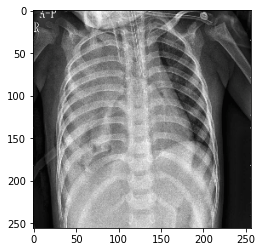

In [ ]:
plt.imshow((X[13]),cmap=plt.cm.bone)

In [ ]:
print(np.asarray(X).shape)

(288, 256, 256, 3)


In [ ]:
X = np.asarray(X)
y = np.asarray(y)

Model for clahe

In [ ]:
%tensorflow_version 1.x
import tensorflow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:

from keras import backend as K
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

230
230
58
58


In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_test)
y_val = np.asarray(y_test)

Encodey_train

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y_train=y_train.reshape(-1,1)
yfunc=enc.fit(y_train)

In [ ]:
y_binary=enc.transform(y_train).toarray()

In [ ]:
y_binary.shape

(230, 2)

Reshape x_train for giving input to conv layers

In [ ]:
X_train.shape

(230, 256, 256, 3)

SWISH ACTIVATION FUNCTION

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x)) 
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})    

In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same')) #,activation='swish'))
model.add(layers.BatchNormalization())
model.add(Activation('swish'))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same')) #,activation='swish'))
model.add(layers.BatchNormalization())
model.add(Activation('swish'))

model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))#,activation='swish'))
model.add(layers.BatchNormalization())
model.add(Activation('swish'))

model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same')) #,activation='swish'))
model.add(layers.BatchNormalization())
model.add(Activation('swish'))


model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same')) #,activation='swish'))
model.add(layers.BatchNormalization())
model.add(Activation('swish'))

 
model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same')) #,activation='swish'))
model.add(Activation('swish'))
 
model.add(layers.Flatten())
 
model.add(layers.Dense(1, activation='sigmoid'))



In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('nor_vs_cov_swish.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=model.fit(X_train,y_train,batch_size=16,validation_data=(X_test,y_test),epochs=100,callbacks=[es,mc])

Train on 230 samples, validate on 58 samples
Epoch 1/100
230/230 [==============================] - 24s 103ms/step - loss: 0.3931 - accuracy: 0.8043 - val_loss: 0.6466 - val_accuracy: 0.7069

Epoch 00001: val_accuracy improved from -inf to 0.70690, saving model to nor_vs_cov_swish.h5


AttributeError: ignored

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show() 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

SWISH ACTIVATION FUNCTION 


In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters=8,kernel_size=(3,3),input_shape=(256,256,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(filters=16,kernel_size=(1,1),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2))

model.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
 
model.add(layers.Conv2D(filters=2,kernel_size=(3,3),strides=1,padding='same'))
 
model.add(layers.Flatten())
 
model.add(layers.Dense(1, activation='sigmoid'))
# load weights into new model
model.load_weights("best_model_clahe_nor_vs_cov.h5")

In [ ]:
x_test=[]
y_test=[]

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid-viral/test/*bacterial*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  x_test.append(img)
  y_test.append(0)


In [ ]:
for im in glob.glob('/content/drive/My Drive/covid-viral/test/*covid*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  x_test.append(img)
  y_test.append(1)

In [ ]:
print(len(x_test))
print(len(y_test))

In [ ]:
for i in range(20):
    img = x_test[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    x_test[i]=img

print('Shape of train images: ', x_test[0].shape)

In [ ]:
x_test=np.array(x_test)
print(x_test.shape)

In [ ]:
y_test=np.array(y_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y_test=np.asarray(y_test).reshape(-1,1)
yfunc=enc.fit(y_test)
y_binary=enc.transform(y_test).toarray()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(model.summary())

In [ ]:
y_test=y_test.reshape(-1,1)

In [ ]:
y_pred.shape

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
print("test accuracy: ",test_acc,)
print("test loss    : ",_)

In [ ]:
label = []
classes = []
for i in y_pred:
  if i>0.5:
    label.append(1)
    classes.append('COVID-19')
  else :
    label.append(0)
    classes.append('Bacterial') 
print(len(label))
label = np.asarray(label)
label=label.reshape(-1,1)

In [ ]:
print("Prediction score\t\tPrediction Label\t\tPredicted Class\n")
for i in range(20):
    print((float)(y_pred[i]),"\t\t",(str)(label[i][0]),"\t\t\t\t",(str)(classes[i]))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,label))

TMC XRAY images

In [ ]:
samples = []
x_samples =[]
y_samples = []

In [ ]:
for im in glob.glob('/content/drive/My Drive/covid TMC/*covid*.*'):
  #print(im)
  img=cv2.imread(im,1)
  img=cv2.resize(img,(256,256))
  samples.append(img)
  y_samples.append(1)

In [ ]:
print(len(samples))
print(len(y_samples))

In [ ]:
for i in range(11):
    img = samples[i]
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(16,16))

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    """img = np.power(img, gamma)""" 
    x_samples.append(img)

In [ ]:
len(x_samples)

In [ ]:
fig,a =  plt.subplots(3,2,figsize=(15,15))
a[0][0].imshow((samples[0]),cmap=plt.cm.bone)
a[0][0].set_title('sample COVID image-1')
a[0][0].axis('off')
a[0][1].imshow((x_samples[0]),cmap=plt.cm.bone)
a[0][1].set_title('preprocessed COVID image-1')
a[0][1].axis('off')
a[1][0].imshow((samples[1]),cmap=plt.cm.bone)
a[1][0].set_title('sample COVID image-2')
a[1][0].axis('off')
a[1][1].imshow((x_samples[1]),cmap=plt.cm.bone)
a[1][1].set_title('preprocessed COVID image-2')
a[1][1].axis('off')
a[2][0].imshow((samples[2]),cmap=plt.cm.bone)
a[2][0].set_title('sample COVID image-2')
a[2][0].axis('off')
a[2][1].imshow((x_samples[2]),cmap=plt.cm.bone)
a[2][1].set_title('preprocessed COVID image-2')
a[2][1].axis('off')

plt.show()

In [ ]:
print('Shape of sample images: ', x_samples[0].shape)

In [ ]:
x_samples=np.array(x_samples)
print(x_samples.shape)

In [ ]:
y_samples_pred=model.predict(x_samples)

In [ ]:
sample_labels = []
for i in y_samples_pred:
  if i>0.5:
    sample_labels.append('COVID-19')
  else :
    sample_labels.append('viral') 
print(len(sample_labels))
sample_labels = np.asarray(sample_labels)
sample_labels=sample_labels.reshape(-1,1)

In [ ]:
print("Prediction score\t\tPrediction Label\n")
for i in range(11):
    print((float)(y_samples_pred[i]),"\t\t",(str)(sample_labels[i][0]))